In [1]:
import numpy as np
from numpy import logical_or as lor
from numpy import logical_and as land
from numpy import logical_not as lnot
from numpy import logical_xor as lxor
import random
import matplotlib.pyplot as plt
import random

from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.svm import SVC, SVR

Ideally, we want the selection algorithms to identify only the relevant variables or the corresponding redundant variables without duplications. However, given the correlation between the relevant and redundant variables, it is not surprising that in most cases the selection algorithms identify both sets of features which results in the duplication of features. A robust selection algorithm should also discard irrelevant variables that are randomly correlated with the target variable.

We observe that the selection algorithms are highly capable of identifying the relevant variables. However, the algorithms also often select the redundant and correlated (irrelevant) variables. 
Therefore, we propose a two-stage selection approach. In the first stage, the top features are selected which will likely inlcude the majority of the relevant variables as well as several redundant and irrelevant variables. In the second stage, an exhaustive search over the set of all possible combinations of the selected variables is conducted to identify the optimal feature subset.
The exhaustive search is the gold standard of feature selection but it is impractacial due to the large number of features in the original set. Therefore, by reducing the number of features in the first stage of the proposed selection approach we are able to perform exhaustive search in practice. Our experiments show that the selection agorithms often rank the relevant features high enough to pass the first stage of the selection process. Thus, the proposed approach allows us to reduce the search space of the feature combinations without the loss of the relevant features.

### ORAND

In [2]:
def gen_3():
  rlvnt = []
  for i in [0,1]:
    for j in [0,1]:
      for k in [0,1]:
        rlvnt.append([i,j,k])
  return rlvnt

def make_cor(y):
  cor_vars = []
  for i in range(2):
    cor_i = y.copy()
    ind = random.sample(range(len(y)), 15)
    cor_i[ind] = lnot(cor_i[ind])
    cor_vars.append(cor_i)
  return np.array(cor_vars).transpose()

def orand(n_obs=50,n_I=92, seed=0):
  np.random.seed(seed)
  red = lnot(gen_3()).astype(int)
  rr = np.hstack([gen_3(), red])
  q=n_obs//8
  r=n_obs%8
  rr_exp = np.vstack([np.repeat(rr,q, axis=0),rr[:r,:]])
  irlvnt = np.random.randint(2, size=[n_obs,n_I], )
  y = land(rr_exp[:,0], 
           lor(rr_exp[:,1], rr_exp[:,2])).astype(int)
  cor = make_cor(y)
  features = np.hstack([rr_exp,cor, irlvnt])
  return features, y

X, y = orand(seed=1)

### ANDOR

In [3]:
def gen_4():
  rlvnt_0 = gen_3()
  for seq in rlvnt_0:
    seq.append(0)

  rlvnt_1 = gen_3()
  for seq in rlvnt_1:
    seq.append(1)

  return rlvnt_0 + rlvnt_1


def andor(n_obs=50,n_I=90, seed=0):
  np.random.seed(seed)
  red = lnot(gen_4()).astype(int)
  rr = np.hstack([gen_4(), red])
  q=n_obs//16
  r=n_obs%16
  rr_exp = np.vstack([np.repeat(rr,q, axis=0),rr[:r,:]])
  irlvnt = np.random.randint(2, size=[n_obs,n_I])
  y = lor(land(rr_exp[:,0], rr_exp[:,1]), 
          land(rr_exp[:,2], rr_exp[:,3])).astype(int)
  cor = make_cor(y)
  features = np.hstack([rr_exp, cor, irlvnt])
  return features, y

X, y = andor()

### ADDER

In [4]:
def make_cor_adv(y, n_ind=15, n_class=4):
  cor_vars = []
  for i in range(2):
    cor_i = y.copy()
    ind = random.sample(range(len(y)), n_ind)
    cor_i[ind] = (cor_i[ind]+1)%n_class
    cor_vars.append(cor_i)
  return np.array(cor_vars).transpose()

In [5]:
def adder(n_obs=50,n_I=92, seed=0):
  np.random.seed(seed)
  red = lnot(gen_3()).astype(int)
  rr = np.hstack([gen_3(), red])
  q=n_obs//8
  r=n_obs%8
  rr_exp = np.vstack([np.repeat(rr,q, axis=0),rr[:r,:]])
  irlvnt = np.random.randint(2, size=[n_obs,n_I])
  y1 = lxor(lxor(rr_exp[:,0], rr_exp[:,1]), 
            rr_exp[:,2]).astype(int)
  y2 = lor(land(rr_exp[:,0], rr_exp[:,1]), 
           land(rr_exp[:,2], lxor(rr_exp[:,0], rr_exp[:,1]))).astype(int)
  y = [y1[j] + 2*y2[j] for j in range(len(y1))]
  cor = make_cor_adv(np.array(y))
  features = np.hstack([rr_exp, cor, irlvnt])
  return features, y

X, y = adder(n_obs=50,n_I=90)

### LED

In [6]:
import pandas as pd
df = pd.read_csv('16_segment_truth_table2.csv')
df = df.fillna(0)
df.index = df.iloc[:,0].values
df.drop(columns='char', inplace=True)
df = df.astype(int)

def led(df, n_obs=180,n_I=66, seed=0):
    np.random.seed(seed)
    rlvnt = df.values
    red = np.logical_not(rlvnt)
    rr = np.hstack([rlvnt, red])
    d = rlvnt.shape[0]
    q=n_obs//d
    r=n_obs%d
    rr_exp = np.vstack([np.repeat(rr, q, axis=0), rr[:r,:]])
    irlvnt = np.random.randint(2, size=[n_obs,n_I])
    y = np.array(range(36))
    y = np.hstack([np.repeat(y, q), y[:r]])
    cor = make_cor_adv(y, n_ind=54, n_class=36)
    features = np.hstack([rr_exp, cor, irlvnt])
    return features, y
    
    
X, y = led(n_obs=180,n_I=90, df=df)

### PRC

In [7]:
def r_total(r_array):
  r_sum = 0
  for k in range(5):
    rk_sum = 1
    for j in range(5):
      if j!=k:
        rk_sum = rk_sum*r_array[j]
    r_sum = r_sum + rk_sum
  return np.product(r_array)/r_sum


def prc_old(n_obs,n_I, seed):
  np.random.seed(seed)
  rlvnt = np.random.randn(n_obs,5)
  for k in range(5):
    rlvnt[:,k] = 3 + rlvnt[:,k]/(k+1)
  red = 2*rlvnt+3
  rr = np.hstack([rlvnt, red])

  irlvnt = np.random.randn(n_obs,n_I//2)
  for k in range(5):
    irlvnt[:,9*k:9*(k+1)] = 3 + irlvnt[:,9*k:9*(k+1)]/(k+1)
  irlvnt = np.hstack([irlvnt, np.random.rand(n_obs,n_I//2)])
  
  features = np.hstack([rr, irlvnt])
  y = [r_total(features[j,:5]) for j in range(features.shape[0])]
  return features, y


def prc(n_obs,n_I, seed):
  np.random.seed(seed)
  rlvnt = 3 + np.random.randn(n_obs,5)/3
  red = 2*rlvnt+3
  rr = np.hstack([rlvnt, red])

  irlvnt = 3 + np.random.randn(n_obs,n_I//2)/3
  irlvnt = np.hstack([irlvnt, 3+np.random.rand(n_obs,n_I//2)])
  
  features = np.hstack([rr, irlvnt])
  y = [r_total(features[j,:5]) for j in range(features.shape[0])]
  return features, y

X, y = prc(50, 90, 0)

## ANDOR

## 1.13.2. Univariate feature selection¶

Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator. Scikit-learn exposes feature selection routines as objects that implement the transform method:

* SelectKBest removes all but the  highest scoring features

* SelectPercentile removes all but a user-specified highest scoring percentage of features using common univariate statistical tests for each feature: false positive rate 

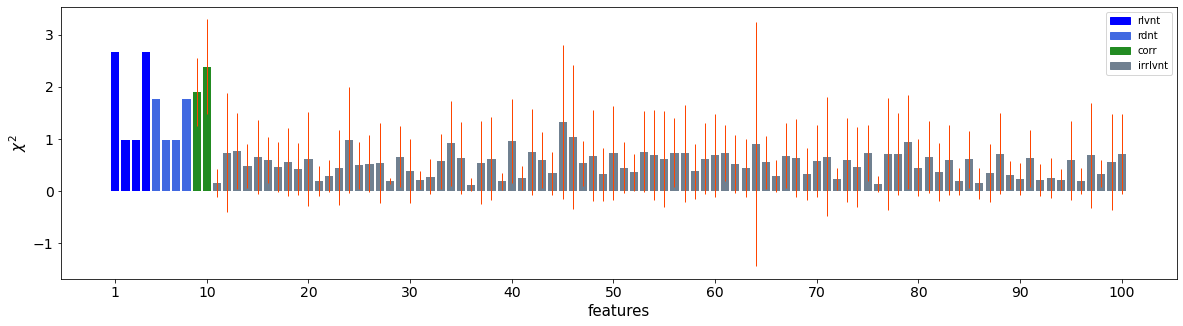

In [9]:
best_scores = []
for i in range(10):
    X, y = andor(n_obs=20,seed=i)
    sel_kbest = SelectKBest(chi2, k=1)
    sel_kbest = sel_kbest.fit(X, y)
    best_scores.append(sel_kbest.scores_)


plt.figure(figsize=(20,5))
mean_scores = np.array(best_scores).mean(axis=0)
sd_scores = np.array(best_scores).std(axis=0)
plt.bar(range(1, X.shape[1]+1),mean_scores, yerr=sd_scores, ecolor='orangered', 
        color=4*["blue"]+4*["royalblue"]+2*["forestgreen"]+90*["slategray"],
        error_kw=dict(lw=1))
plt.xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], size=14)
plt.yticks(size=14)
plt.xlabel('features', size=15)
plt.ylabel(r'$\chi^2$', size=15)
#plt.title('Univariate')

colors = {'rlvnt':'blue', 'rdnt':'royalblue', 'corr':'forestgreen', 'irrlvnt':'slategray'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.savefig('uni_20.pdf', bbox_inches='tight')
plt.show()

## 1.13.3. Recursive feature elimination¶
Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through any specific attribute (such as coef_, feature_importances_) or callable. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

RFECV performs RFE in a cross-validation loop to find the optimal number of features.

In [79]:
np.random.seed(123)
random.seed(123)

rankings = []
for i in range(10):
    X, y = andor(n_obs=50,seed=i)
    estimator = SVC(kernel="linear", random_state=123)
    selector = RFE(estimator, n_features_to_select=1, step=1)
    selector = selector.fit(X, y)
    rankings.append(selector.ranking_)
    
rankings = np.array(rankings)[:,:8]
rankings

array([[15, 14,  4, 13,  3,  2, 18,  1],
       [12,  5, 23, 10,  9,  8, 11,  3],
       [12, 16,  5,  6,  3,  1,  2,  9],
       [22, 13,  5,  3,  6, 17, 11, 14],
       [ 2,  7,  9,  6,  8,  4,  3,  5],
       [13,  4,  7,  6,  5, 14,  2,  1],
       [14,  5,  4, 15,  3, 11, 12,  2],
       [11, 12,  9,  6,  5,  2,  4,  3],
       [ 6, 13, 12,  4, 14,  7, 10,  8],
       [ 7, 11, 13, 14,  3,  8, 10,  6]])

In [80]:
np.median(rankings, axis=0)

array([12. , 11.5,  8. ,  6. ,  5. ,  7.5, 10. ,  4. ])

In [69]:
import pandas as pd
print(pd.DataFrame(rankings).style.to_latex())

\begin{tabular}{lrrrrrrrr}
 & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 \\
0 & 5 & 8 & 20 & 6 & 34 & 13 & 39 & 7 \\
1 & 29 & 17 & 8 & 5 & 13 & 9 & 16 & 14 \\
2 & 12 & 7 & 50 & 17 & 4 & 22 & 53 & 8 \\
3 & 5 & 33 & 39 & 12 & 14 & 29 & 46 & 3 \\
4 & 16 & 35 & 32 & 9 & 22 & 13 & 26 & 11 \\
5 & 36 & 11 & 17 & 5 & 28 & 4 & 21 & 6 \\
6 & 18 & 22 & 37 & 11 & 10 & 35 & 33 & 5 \\
7 & 14 & 6 & 17 & 12 & 18 & 28 & 4 & 10 \\
8 & 13 & 43 & 7 & 42 & 9 & 37 & 23 & 30 \\
9 & 23 & 19 & 27 & 11 & 6 & 20 & 31 & 3 \\
\end{tabular}



## 1.13.4. Feature selection using SelectFromModel

SelectFromModel is a meta-transformer that can be used alongside any estimator that assigns importance to each feature through a specific attribute (such as coef_, feature_importances_) or via an importance_getter callable after fitting. The features are considered unimportant and removed if the corresponding importance of the feature values are below the provided threshold parameter. Apart from specifying the threshold numerically, there are built-in heuristics for finding a threshold using a string argument. Available heuristics are “mean”, “median” and float multiples of these like “0.1*mean”. In combination with the threshold criteria, one can use the max_features parameter to set a limit on the number of features to select.

### 1.13.4.1. L1-based feature selection
Linear models penalized with the L1 norm have sparse solutions: many of their estimated coefficients are zero. When the goal is to reduce the dimensionality of the data to use with another classifier, they can be used along with SelectFromModel to select the non-zero coefficients. In particular, sparse estimators useful for this purpose are the Lasso for regression, and of LogisticRegression and LinearSVC for classification:

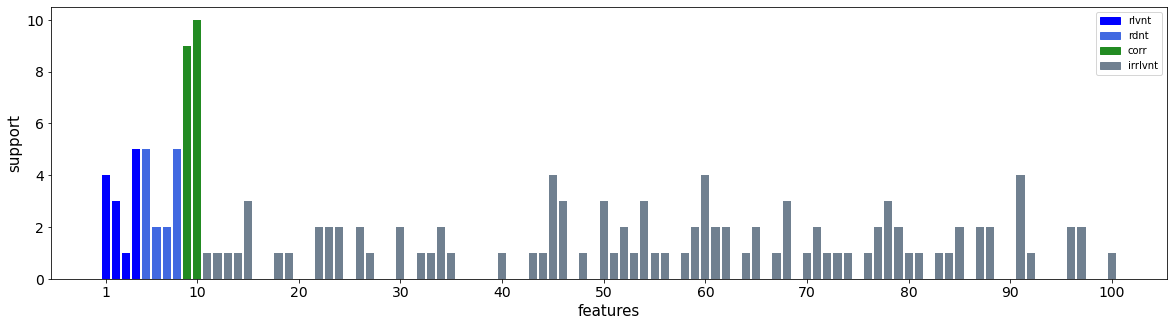

In [11]:
np.random.seed(123)
random.seed(123)

rankings = []
for i in range(10):
    X, y = andor(n_obs=20, seed=i)
    lsvc = LinearSVC(C=0.5, penalty="l1", dual=False, random_state=123).fit(X, y)
    model = SelectFromModel(lsvc, prefit=True)
    rankings.append(model.get_support())

plt.figure(figsize=(20,5))
plt.bar(range(1, X.shape[1]+1),sum(rankings), 
        color=4*["blue"]+4*["royalblue"]+2*["forestgreen"]+90*["slategray"],
        error_kw=dict(lw=1))
plt.xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], size=14)
plt.yticks(size=14)
plt.xlabel('features', size=15)
plt.ylabel('support', size=15)
#plt.title('L1')

colors = {'rlvnt':'blue', 'rdnt':'royalblue', 'corr':'forestgreen', 'irrlvnt':'slategray'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.savefig('lsvc_20.pdf', bbox_inches='tight')
plt.show()

### 1.13.4.2. Tree-based feature selection
Tree-based estimators (see the sklearn.tree module and forest of trees in the sklearn.ensemble module) can be used to compute impurity-based feature importances, which in turn can be used to discard irrelevant features (when coupled with the SelectFromModel meta-transformer):

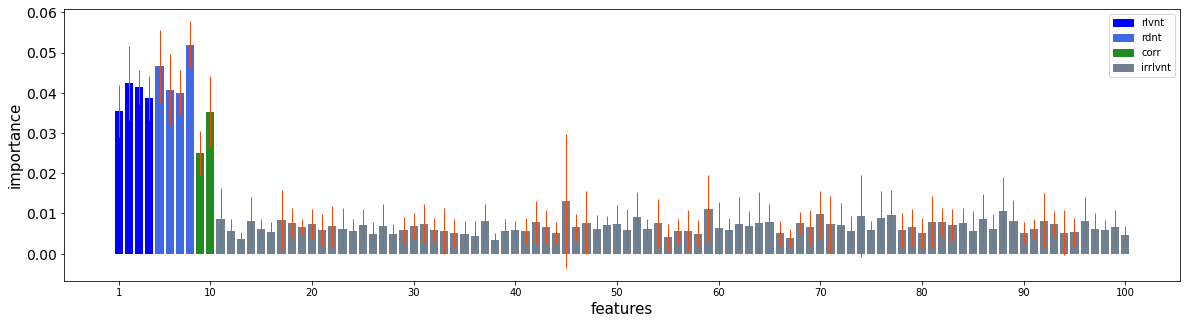

In [13]:
np.random.seed(123)
random.seed(123)

best_scores = []
for i in range(10):
    X, y = andor(n_obs=50,seed=i)
    clf = ExtraTreesClassifier(n_estimators=50, random_state=123)
    clf = clf.fit(X, y)
    best_scores.append(clf.feature_importances_)

plt.figure(figsize=(20,5))
mean_scores = np.array(best_scores).mean(axis=0)
sd_scores = np.array(best_scores).std(axis=0)
plt.bar(range(1, X.shape[1]+1),mean_scores, yerr=sd_scores, ecolor='orangered', 
        color=4*["blue"]+4*["royalblue"]+2*["forestgreen"]+90*["slategray"],
        error_kw=dict(lw=1))

plt.xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.yticks(size=14)
plt.xlabel('features', size=15)
plt.ylabel('importance', size=15)
#plt.title('Tree')

colors = {'rlvnt':'blue', 'rdnt':'royalblue', 'corr':'forestgreen', 'irrlvnt':'slategray'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.savefig('tree_50.pdf', bbox_inches='tight')
plt.show()

## ORAND

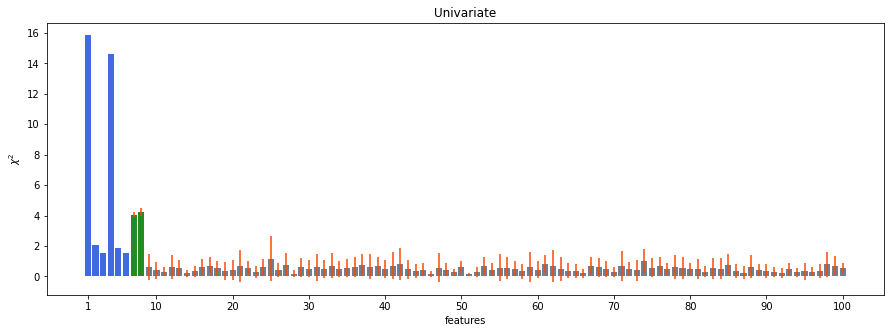

In [42]:
best_scores = []
for i in range(10):
    X, y = orand(seed=i)
    sel_kbest = SelectKBest(chi2, k=1)
    sel_kbest = sel_kbest.fit(X, y)
    best_scores.append(sel_kbest.scores_)



plt.figure(figsize=(15,5))
mean_scores = np.array(best_scores).mean(axis=0)
sd_scores = np.array(best_scores).std(axis=0)
plt.bar(range(1, X.shape[1]+1),mean_scores, yerr=sd_scores, ecolor='orangered', 
        color=6*["royalblue"]+2*["forestgreen"]+92*["slategray"])
#plt.yticks([0, 5, 10, 15])
plt.xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.xlabel('features')
plt.ylabel(r'$\chi^2$')
plt.title('Univariate')
plt.show()

In [44]:
rankings = []
for i in range(10):
    X, y = orand(seed=i)
    estimator = SVC(kernel="linear")
    selector = RFE(estimator, n_features_to_select=1, step=1)
    selector = selector.fit(X, y)
    rankings.append(selector.ranking_)
    
np.array(rankings)[:,:6]

array([[ 2, 18,  9,  1, 16,  3],
       [ 2,  8,  9,  1,  4, 13],
       [ 2,  6, 26,  1, 10,  4],
       [ 2,  4,  3,  1, 11,  8],
       [ 2, 23, 11,  1,  4,  3],
       [ 2,  8, 12,  1,  4,  3],
       [ 2,  5,  7,  1,  8,  4],
       [ 2, 15,  9,  1,  4,  3],
       [ 2,  6,  5,  1,  4,  3],
       [ 2, 10, 19,  1,  3,  9]])

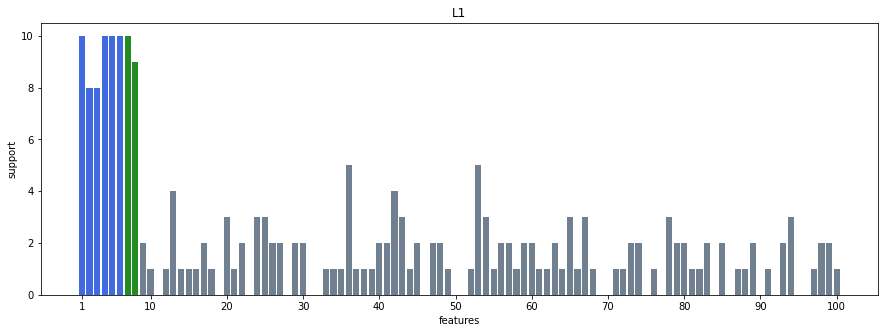

In [46]:
rankings = []
for i in range(10):
    X, y = orand(seed=i)
    lsvc = LinearSVC(C=0.5, penalty="l1", dual=False).fit(X, y)
    model = SelectFromModel(lsvc, prefit=True)
    rankings.append(model.get_support())

plt.figure(figsize=(15,5))
#plt.bar(range(1, X.shape[1]+1),sum(rankings), color="royalblue")
plt.bar(range(1, X.shape[1]+1),sum(rankings), 
        color=6*["royalblue"]+2*["forestgreen"]+92*["slategray"])
plt.xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.xlabel('features')
plt.ylabel('support')
plt.title('L1')
plt.show()

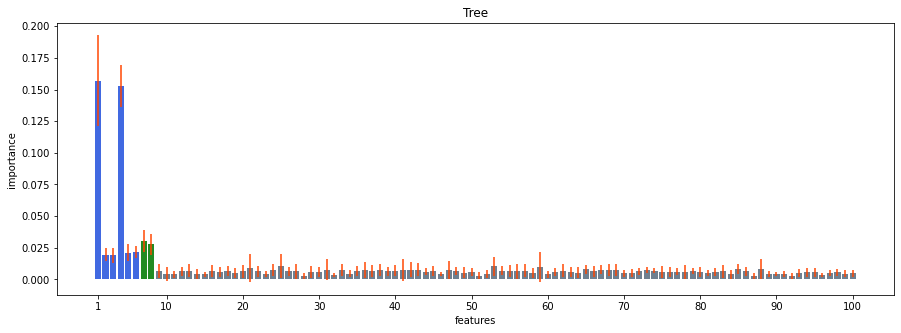

In [47]:
best_scores = []
for i in range(10):
    X, y = orand(seed=i)
    clf = ExtraTreesClassifier(n_estimators=50)
    clf = clf.fit(X, y)
    best_scores.append(clf.feature_importances_)

plt.figure(figsize=(15,5))
mean_scores = np.array(best_scores).mean(axis=0)
sd_scores = np.array(best_scores).std(axis=0)
plt.bar(range(1, X.shape[1]+1),mean_scores, yerr=sd_scores, ecolor='orangered', 
        color=6*["royalblue"]+2*["forestgreen"]+92*["slategray"])

plt.xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Tree')

colors = {'rlvnt/rdnt':'royalblue', 'corr':'forestgreen', 'irrlvnt':'slategray'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.savefig('tree_20.pdf', bbox_inches='tight')
plt.show()

## ADDER

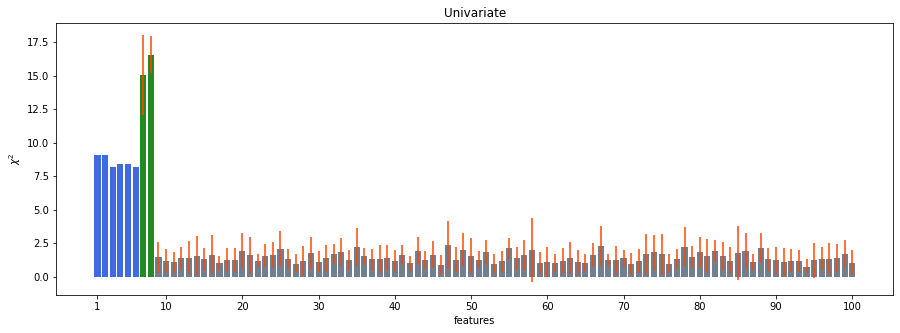

In [16]:
best_scores = []
for i in range(10):
    X, y = adder(seed=i)
    sel_kbest = SelectKBest(chi2, k=1)
    sel_kbest = sel_kbest.fit(X, y)
    best_scores.append(sel_kbest.scores_)



plt.figure(figsize=(15,5))
mean_scores = np.array(best_scores).mean(axis=0)
sd_scores = np.array(best_scores).std(axis=0)
plt.bar(range(1, X.shape[1]+1),mean_scores, yerr=sd_scores, ecolor='orangered', 
        color=6*["royalblue"]+2*["forestgreen"]+92*["slategray"])
#plt.yticks([0, 5, 10, 15])
plt.xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.xlabel('features')
plt.ylabel(r'$\chi^2$')
plt.title('Univariate')
plt.show()

In [19]:
rankings = []
for i in range(10):
    X, y = adder(seed=i)
    estimator = SVC(kernel="linear")
    selector = RFE(estimator, n_features_to_select=1, step=1)
    selector = selector.fit(X, y)
    rankings.append(selector.ranking_)
    
np.array(rankings)[:,:6]

array([[6, 5, 4, 3, 1, 2],
       [6, 5, 4, 3, 1, 2],
       [6, 5, 4, 3, 1, 2],
       [6, 5, 4, 3, 1, 2],
       [6, 5, 4, 3, 1, 2],
       [6, 5, 4, 3, 1, 2],
       [6, 5, 4, 3, 1, 2],
       [6, 5, 4, 3, 1, 2],
       [6, 5, 4, 3, 1, 2],
       [6, 5, 4, 3, 1, 2]])

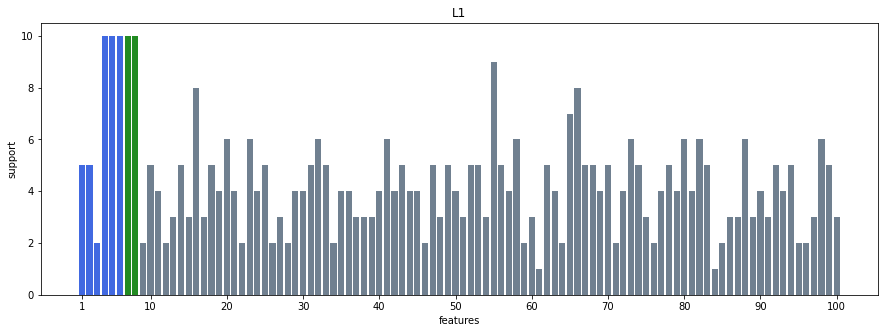

In [25]:
rankings = []
for i in range(10):
    X, y = adder(seed=i)
    lsvc = LinearSVC(C=0.2, penalty="l1", dual=False).fit(X, y)
    model = SelectFromModel(lsvc, prefit=True)
    rankings.append(model.get_support())

plt.figure(figsize=(15,5))
#plt.bar(range(1, X.shape[1]+1),sum(rankings), color="royalblue")
plt.bar(range(1, X.shape[1]+1),sum(rankings), 
        color=6*["royalblue"]+2*["forestgreen"]+92*["slategray"])
plt.xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.xlabel('features')
plt.ylabel('support')
plt.title('L1')
plt.show()

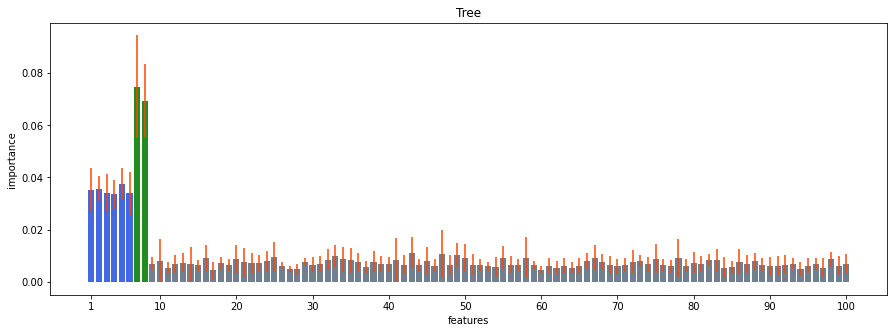

In [26]:
best_scores = []
for i in range(10):
    X, y = adder(seed=i)
    clf = ExtraTreesClassifier(n_estimators=50)
    clf = clf.fit(X, y)
    best_scores.append(clf.feature_importances_)

plt.figure(figsize=(15,5))
mean_scores = np.array(best_scores).mean(axis=0)
sd_scores = np.array(best_scores).std(axis=0)
plt.bar(range(1, X.shape[1]+1),mean_scores, yerr=sd_scores, ecolor='orangered', 
        color=6*["royalblue"]+2*["forestgreen"]+92*["slategray"])

plt.xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Tree')
plt.show()

## LED

In [54]:
import pandas as pd
df = pd.read_csv('16_segment_truth_table2.csv')
df = df.fillna(0)
df.index = df.iloc[:,0].values
df.drop(columns='char', inplace=True)
df = df.astype(int)

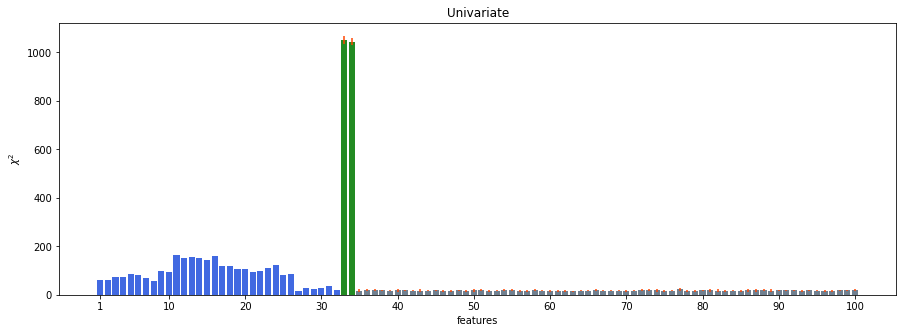

In [55]:
best_scores = []
for i in range(10):
    X, y = led(df, n_obs=180,n_I=66, seed=i)
    sel_kbest = SelectKBest(chi2, k=1)
    sel_kbest = sel_kbest.fit(X, y)
    best_scores.append(sel_kbest.scores_)



plt.figure(figsize=(15,5))
mean_scores = np.array(best_scores).mean(axis=0)
sd_scores = np.array(best_scores).std(axis=0)
plt.bar(range(1, X.shape[1]+1),mean_scores, yerr=sd_scores, ecolor='orangered', 
        color=32*["royalblue"]+2*["forestgreen"]+66*["slategray"])
#plt.yticks([0, 5, 10, 15])
plt.xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.xlabel('features')
plt.ylabel(r'$\chi^2$')
plt.title('Univariate')
plt.show()

In [38]:
rankings = []
for i in range(10):
    X, y = led(df, n_obs=180,n_I=66, seed=i)
    estimator = SVC(kernel="linear")
    selector = RFE(estimator, n_features_to_select=1, step=1)
    selector = selector.fit(X, y)
    rankings.append(selector.ranking_)
    
np.array(rankings)[:,:34]

array([[26, 24, 12, 15, 13,  5, 10,  7, 14, 19, 69, 27, 32, 16, 20, 99,
        22, 25, 18,  6,  8,  3,  4, 17, 11, 21, 77, 31, 40,  9, 23, 96,
         1,  2],
       [31, 27, 16,  6, 10, 14,  4, 12, 15, 21, 87, 34,  2, 20, 26, 22,
        24, 29, 11, 13,  3,  7,  9, 17, 18, 23, 83, 35,  8, 25, 19, 28,
         1,  5],
       [29, 27, 19, 13,  6, 11,  9, 15, 14, 22, 84, 28, 10, 20, 18, 31,
        24, 21, 16,  7,  2,  8,  3, 12, 17, 25, 72, 30,  5, 26, 23, 33,
         1,  4],
       [29, 24, 18,  6,  7, 15, 10,  8, 17, 16, 78, 30,  9, 22, 19, 27,
        31, 26, 12, 14,  2, 11,  4, 13, 20, 21, 83, 32,  3, 28, 25, 23,
         1,  5],
       [27, 26, 17, 15, 10,  8,  9, 14, 12, 22, 56, 30, 29, 13, 19, 98,
        21, 23, 11,  6,  5,  2,  4, 18, 16, 20, 64, 35, 37,  7, 24, 99,
         3,  1],
       [27, 26, 19,  7,  2, 11,  8, 17, 18, 22, 66, 28,  5, 21, 20, 36,
        29, 23, 15, 10,  9,  6,  3, 14, 13, 24, 74, 32, 12, 16, 25, 40,
         4,  1],
       [30, 29, 17, 13,  7, 14, 10

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increas

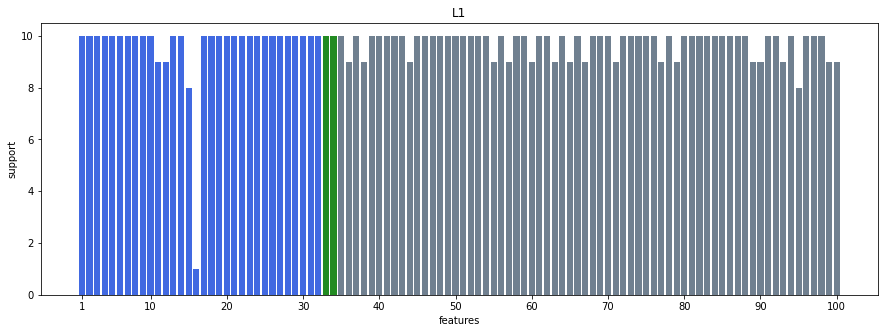

In [88]:
rankings = []
for i in range(10):
    X, y = led(df, n_obs=180,n_I=66, seed=i)
    lsvc = LinearSVC(C=0.2, penalty="l1", dual=False).fit(X, y)
    model = SelectFromModel(lsvc, prefit=True)
    rankings.append(model.get_support())

plt.figure(figsize=(15,5))
plt.bar(range(1, X.shape[1]+1),sum(rankings), 
        color=32*["royalblue"]+2*["forestgreen"]+66*["slategray"])
plt.xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.xlabel('features')
plt.ylabel('support')
plt.title('L1')
plt.show()

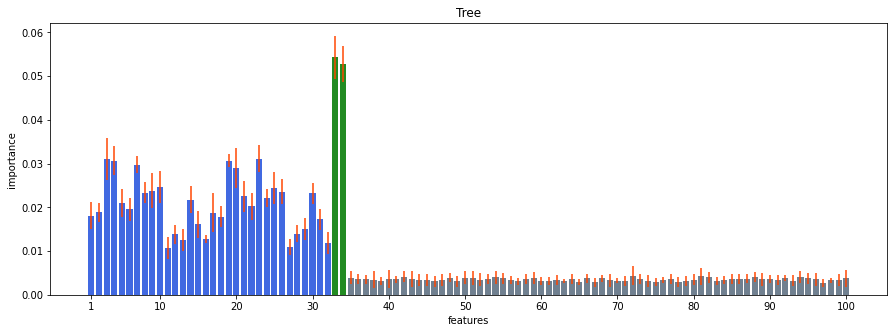

In [37]:
best_scores = []
for i in range(10):
    X, y = led(df, n_obs=180,n_I=66, seed=i)
    clf = ExtraTreesClassifier(n_estimators=50)
    clf = clf.fit(X, y)
    best_scores.append(clf.feature_importances_)

plt.figure(figsize=(15,5))
mean_scores = np.array(best_scores).mean(axis=0)
sd_scores = np.array(best_scores).std(axis=0)
plt.bar(range(1, X.shape[1]+1),mean_scores, yerr=sd_scores, ecolor='orangered', 
        color=32*["royalblue"]+2*["forestgreen"]+66*["slategray"])

plt.xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Tree')
plt.show()

## PRC

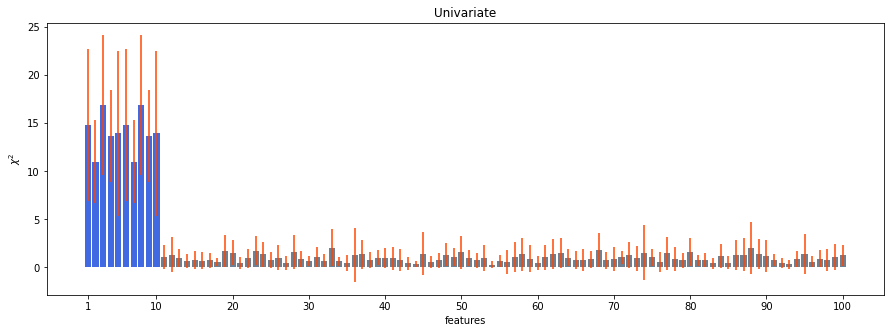

In [79]:
best_scores = []
for i in range(10):
    X, y = prc(n_obs=50,n_I=90, seed=i)
    sel_kbest = SelectKBest(f_regression, k=1)
    sel_kbest = sel_kbest.fit(X, y)
    best_scores.append(sel_kbest.scores_)



plt.figure(figsize=(15,5))
mean_scores = np.array(best_scores).mean(axis=0)
sd_scores = np.array(best_scores).std(axis=0)
plt.bar(range(1, X.shape[1]+1),mean_scores, yerr=sd_scores, ecolor='orangered', 
        color=10*["royalblue"]+90*["slategray"])
#plt.yticks([0, 5, 10, 15])
plt.xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.xlabel('features')
plt.ylabel(r'$\chi^2$')
plt.title('Univariate')
plt.show()

In [80]:
rankings = []
for i in range(10):
    X, y = prc(n_obs=50,n_I=90, seed=i)
    estimator = SVR(kernel="linear")
    selector = RFE(estimator, n_features_to_select=1, step=1)
    selector = selector.fit(X, y)
    rankings.append(selector.ranking_)
    
np.array(rankings)[:,:10]

array([[100,  99,  98,  97,  96,  95,  94,  93,  92,  91],
       [100,  99,  98,  97,  96,  95,  94,  93,  92,  91],
       [100,  99,  98,  97,  96,  95,  94,  93,  92,  91],
       [100,  99,  98,  97,  96,  95,  94,  93,  92,  91],
       [100,  99,  98,  97,  96,  95,  94,  93,  92,  91],
       [100,  99,  98,  97,  96,  95,  94,  93,  92,  91],
       [100,  99,  98,  97,  96,  95,  94,  93,  92,  91],
       [100,  99,  98,  97,  96,  95,  94,  93,  92,  91],
       [100,  99,  98,  97,  96,  95,  94,  93,  92,  91],
       [100,  99,  98,  97,  96,  95,  94,  93,  92,  91]])

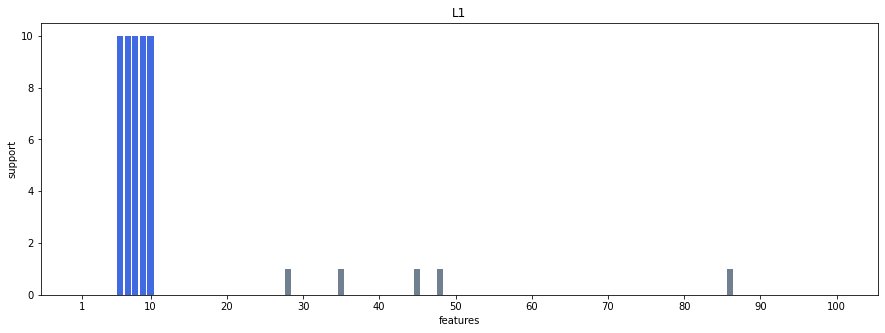

In [86]:
rankings = []
for i in range(10):
    X, y = prc(n_obs=50,n_I=90, seed=i)
    lsvc = Lasso(alpha=0.0005).fit(X, y)
    model = SelectFromModel(lsvc, prefit=True)
    rankings.append(model.get_support())

plt.figure(figsize=(15,5))
plt.bar(range(1, X.shape[1]+1),sum(rankings), 
        color=10*["royalblue"]+2*["forestgreen"]+88*["slategray"])
plt.xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.xlabel('features')
plt.ylabel('support')
plt.title('L1')
plt.show()

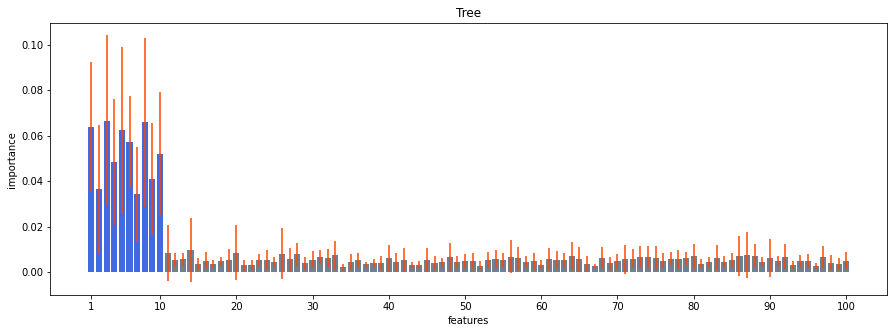

In [87]:
best_scores = []
for i in range(10):
    X, y = prc(n_obs=50,n_I=90, seed=i)
    clf = ExtraTreesRegressor(n_estimators=50)
    clf = clf.fit(X, y)
    best_scores.append(clf.feature_importances_)

plt.figure(figsize=(15,5))
mean_scores = np.array(best_scores).mean(axis=0)
sd_scores = np.array(best_scores).std(axis=0)
plt.bar(range(1, X.shape[1]+1),mean_scores, yerr=sd_scores, ecolor='orangered', 
        color=10*["royalblue"]+90*["slategray"])

plt.xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Tree')
plt.show()